In [20]:
fig_dir = "../../figures/"
fig_ext = "pdf"

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

This notebook is designed to carry out some tests on the HERON hodlr model trainged off the Georgia Tech waveforms (Lomond).

In [22]:
import thesis
from thesis.heron import *

In [23]:
import heron.models.georgebased
import numpy as np
generator = heron.models.georgebased.HeronHodlr(exclude_waveforms=[u'GT0760', u'GT0748', u'GT0757', u'GT0622', u'GT0758', u'GT0654', u'GT0653', u'GT0565', u'GT0884', u'GT0875', u'GT0651'])

Skipped waveform GT0875
Skipped waveform GT0622
Skipped waveform GT0884
Skipped waveform GT0565
Skipped waveform GT0748
Skipped waveform GT0758
Skipped waveform GT0651
Skipped waveform GT0757
Skipped waveform GT0654
Skipped waveform GT0760
Skipped waveform GT0653


In [24]:
import elk
total_mass = generator.total_mass
imr_cat = elk.catalogue.PPCatalogue("IMRPhenomPv2", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo_cat = elk.catalogue.PPCatalogue("SEOBNRv4_ROM", 
                                    total_mass=total_mass, 
                                    fmin=95)
seo3_cat = elk.catalogue.PPCatalogue("SEOBNRv3", 
                                    total_mass=10, 
                                    fmin=95)
nrsur_cat = elk.catalogue.PPCatalogue("NRSur7dq2", 
                                    total_mass=10, 
                                    fmin=95)

In [25]:
sxs_cat = elk.catalogue.NRCatalogue("SXS")

In [7]:
#rit_cat = elk.catalogue.NRCatalogue("RIT")

In [7]:
rows = sxs_cat.table
results = {}

In [8]:
data = pd.read_json("../../data/heron/sxs-matches.json")
approx_results = data.to_dict(orient="index")

In [19]:
approx_results = {}
# Calculate the various matches with surrogate models
for row in rows.iterrows():
    
    row = row[1]
    
    if row['tag'] in data.index: continue
    
    p = {"mass ratio": row['mass_ratio'],
        "spin 1x": row['spin_1x'], "spin 1y": row['spin_1y'], "spin 1z": row['spin_1z'],
        "spin 2x": row['spin_2x'], "spin 2y": row['spin_2y'], "spin 2z": row['spin_2z']
        }
    
    try:
        waveform = [x  for x in sxs_cat.waveforms if x.tag == row['tag'] ][0]

        
        print("Using NR waveform {}".format(row['tag']))
        
        nr_timeseries = waveform.timeseries(total_mass=60, t_max=0.02, t_min=-0.015)
        times = nr_timeseries[0].times
        
        print("\t+Generating mean GPR waveform")

        tdwave = generator.mean(p.copy(), times=times.copy())

        time_range = [times[0], times[-1], len(times)]
        #
        print("\t+Generating approximant waveforms")
        a = imr_cat.waveform(time_range=time_range, p=p.copy())
        time_range[0] /=6
        time_range[1] /=6
        b = seo3_cat.waveform(time_range=time_range, p=p.copy())
        
        b[0].times *= 6
        b[0].data *=6
        b[0].dt = b[0].times[1] - b[0].times[0]

        td_pad = np.pad(tdwave[0].data, (len(a[0].data) - len(tdwave[0].data))/2, "constant", constant_values=0)
        tdwave[0].data = td_pad
        tdwave[0].times = a[0].times
        
        nr_pad = np.pad(nr_timeseries[0].data, (len(a[0].data) - len(nr_timeseries[0].data))/2, 
                        "constant", constant_values=0)
        nr_timeseries[0].data = nr_pad
        nr_timeseries[0].times = a[0].times
        
        
        
        nr_gp_match = match(nr_timeseries[0], tdwave[0])
        print("\tNR match with GP: {}".format(nr_gp_match[0]))
        imr_match = match(a[0], nr_timeseries[0])
        print("\tNR match with IMR: {}".format(imr_match[0]))
        seo_match = match(b[0], nr_timeseries[0])
        print("\tNR match with SEO: {}".format(seo_match[0]))
        imr_gp_match = match(a[0], tdwave[0])
        print("\tGP match with IMR: {}".format(imr_gp_match[0]))
        seo_gp_match = match(b[0], tdwave[0])
        print("\tGP match with SEO: {}".format(seo_gp_match[0]))
        approx_results[row['tag']] ={
                        "waveform": row['tag'], 
                        #"parameters": p, 
                        "nr gp match": nr_gp_match[0], 
                        "imr gp match": imr_gp_match[0], 
                        "seo gp match": seo_gp_match[0],
                        "imr nr match": imr_match[0], 
                        "seo nr match": seo_match[0],
                       }
        
        results_df = pd.DataFrame.from_dict(approx_results, orient='index')
        results_df.to_json("sxs-matches-short.json")
    except:
        pass
    
    

In [26]:
results_df = pd.read_json("../../data/heron/sxs-matches.json")
catalogue = sxs_cat.table
catalogue = catalogue.set_index("tag")
combined = results_df.join(catalogue)

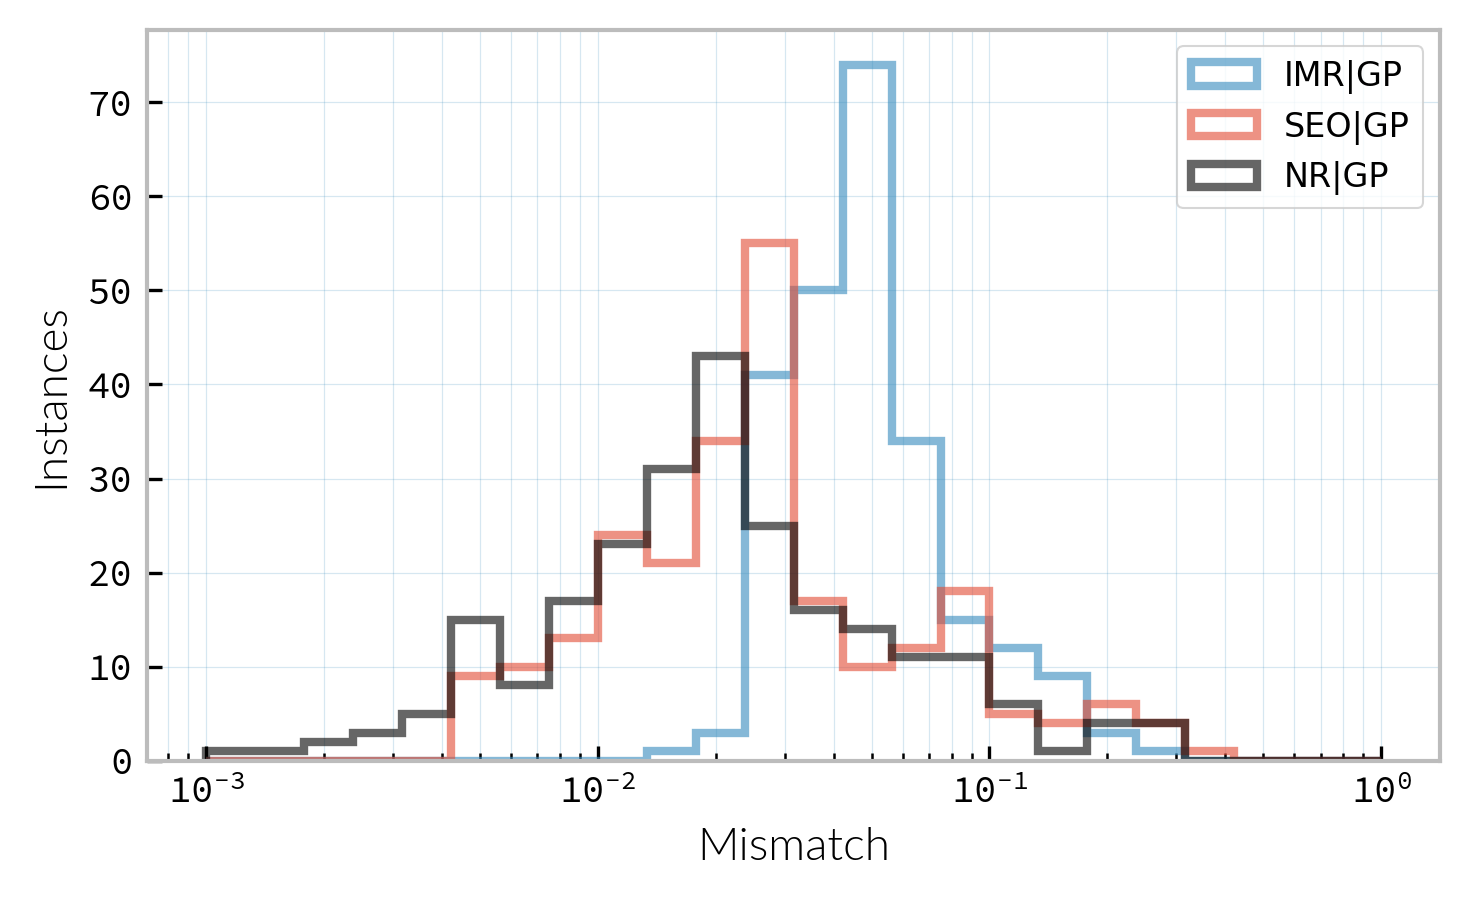

In [27]:
f, ax = plt.subplots(1,1, dpi=300)


ax.set_xscale("log")
#ax.hist(1-combined['imr nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|NR", fc="#348ABD")
#ax.hist(1-combined['seo nr match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|NR", fc="#E24A33")

ax.hist(1-combined['imr gp match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="IMR|GP", ec="#348ABD", lw=2, histtype="step")
ax.hist(1-combined['seo gp match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="SEO|GP", ec="#E24A33", lw=2, histtype="step")

ax.hist(1-combined['nr gp match'], bins=np.logspace(-3,0, 25), alpha=0.6, label="NR|GP", histtype="step", lw=2, 
        ec='k')
plt.legend()

ax.set_xlabel("Mismatch")
ax.set_ylabel("Instances")

f = thesis.thesisify(f)

f.savefig("{}/heron/sxs-sample-hist.{}".format(fig_dir, fig_ext))

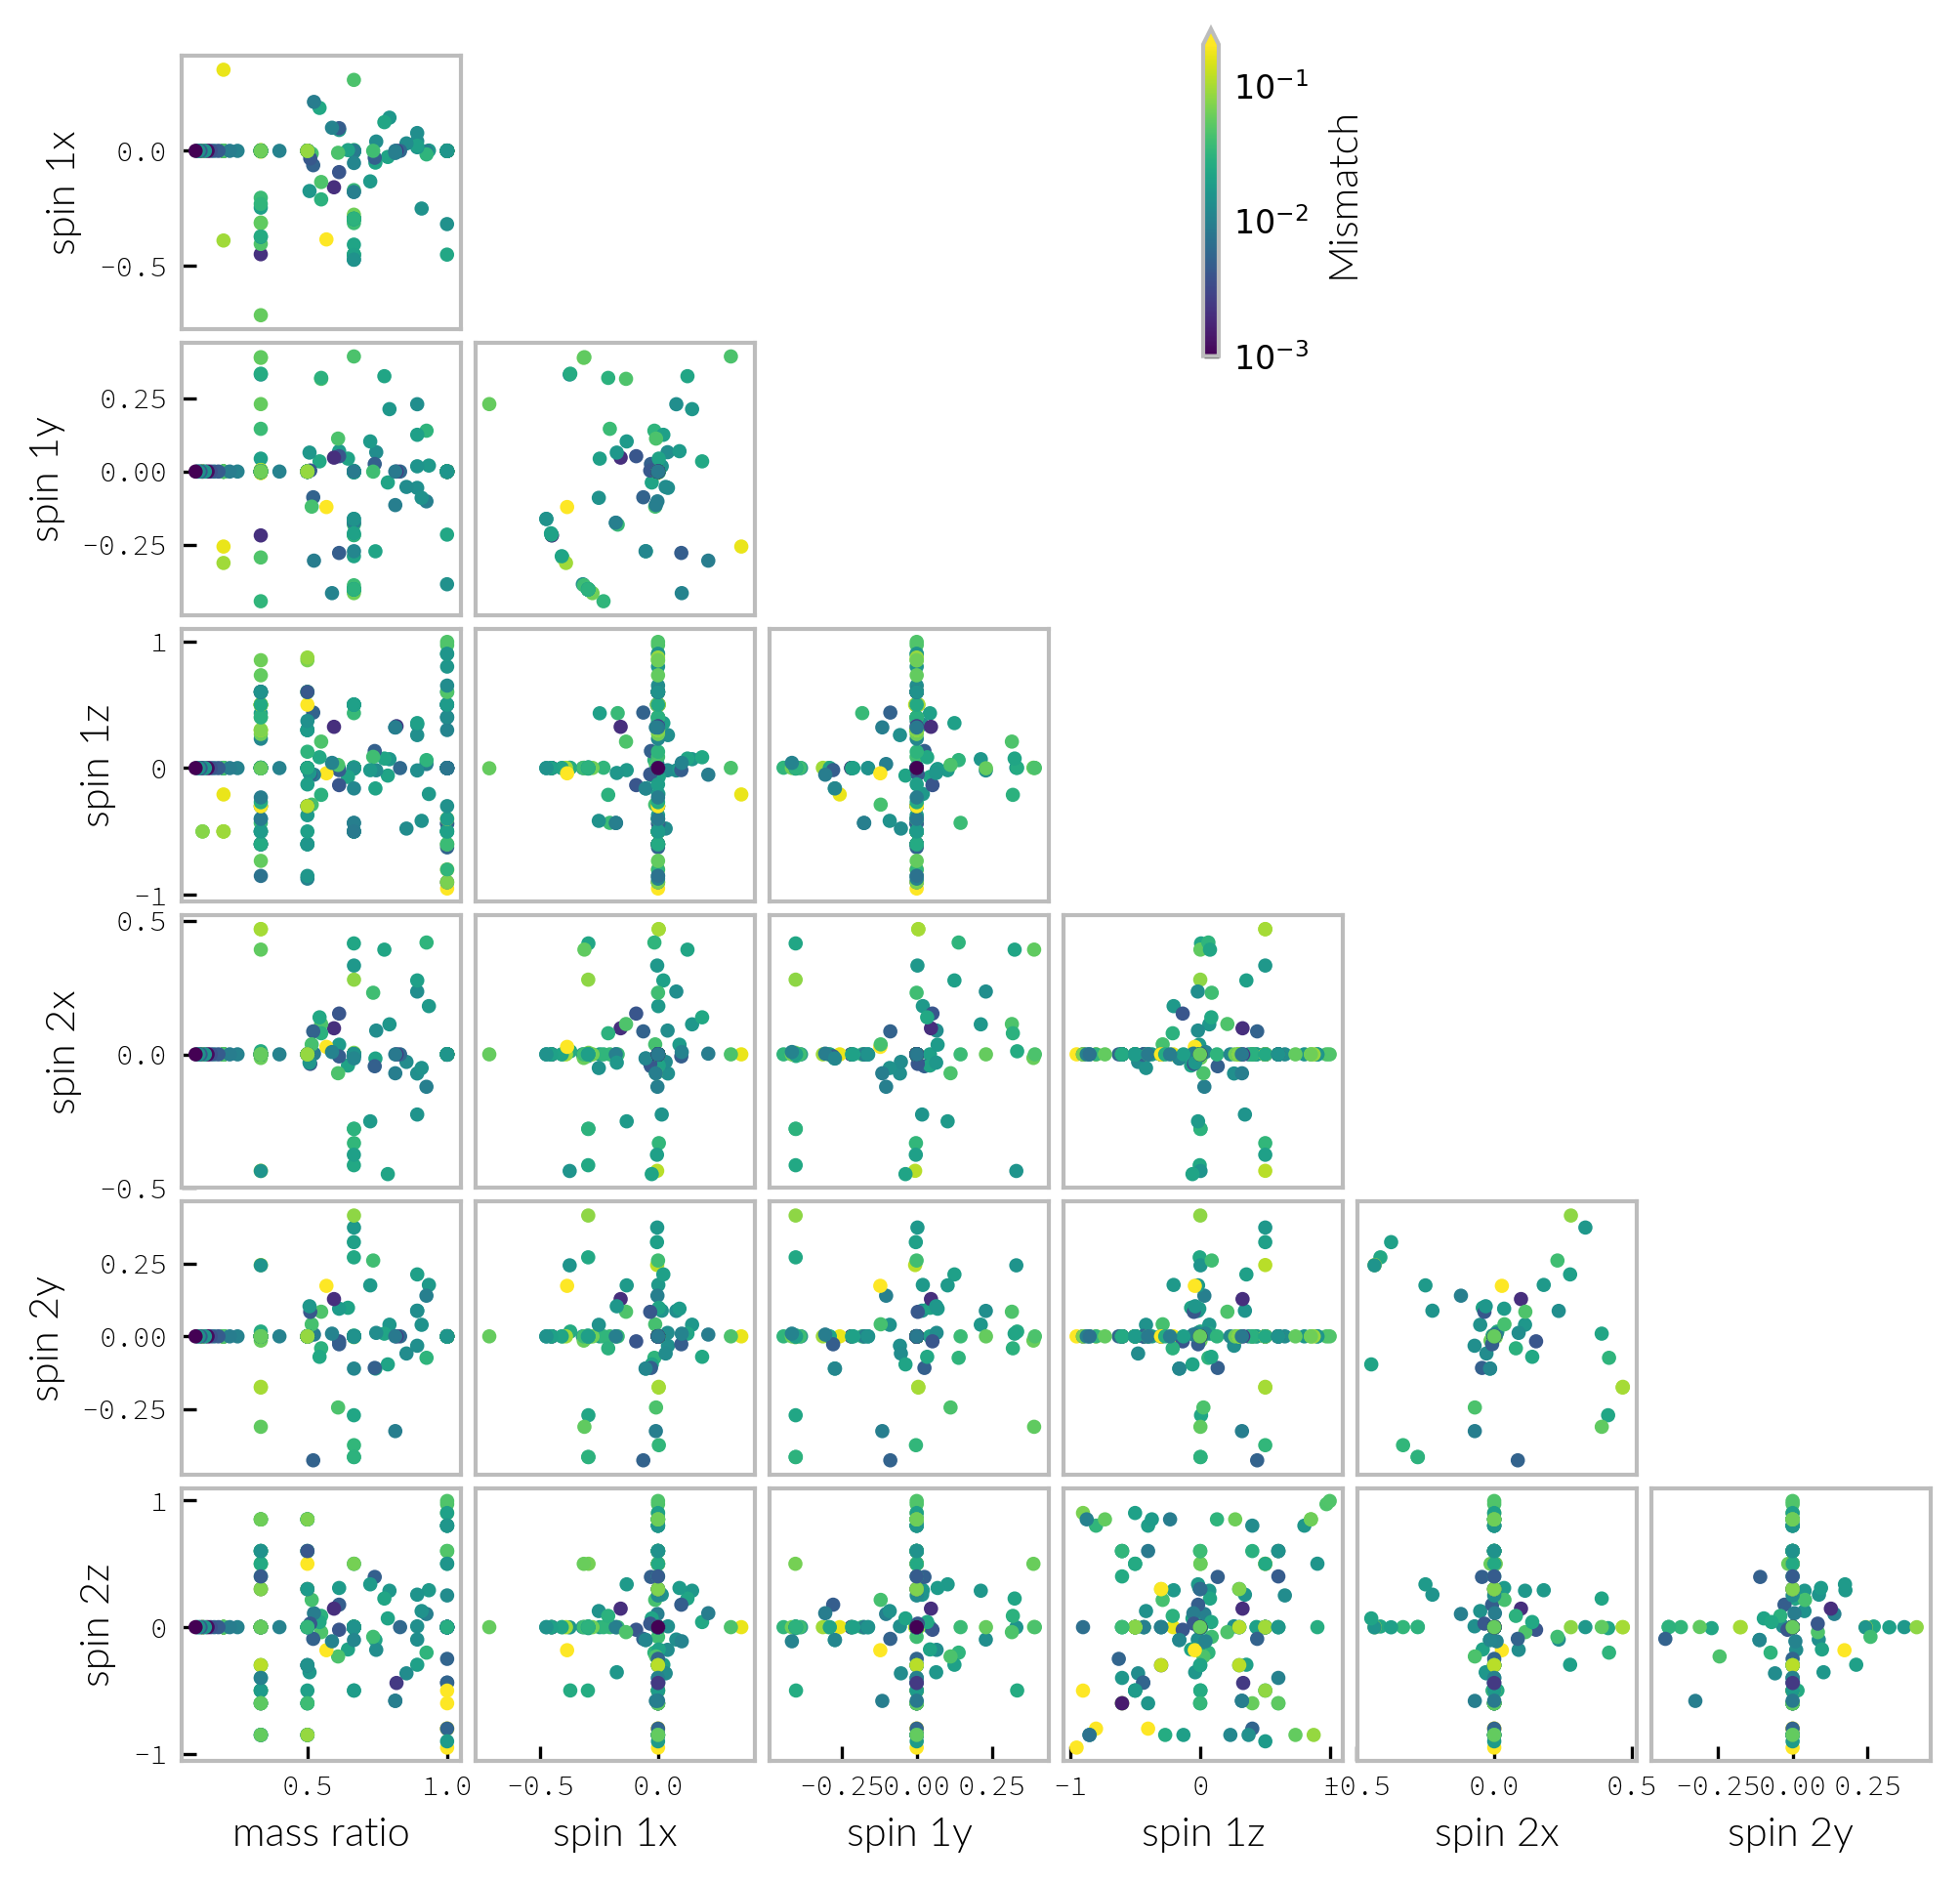

In [28]:
f = triangle_match_plot(data = combined, parameters = ["mass_ratio", "spin_1x", "spin_1y", "spin_1z", "spin_2x", "spin_2y", "spin_2z"], match_col="nr gp match")
f.savefig("{}/heron/sxs_match_triangle.{}".format(fig_dir, fig_ext))